## Yelp EDA

Exploring the CSVs gathered from the API Calls from Yelp for the 5 NYC borougs and Paris

Imports

In [354]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
import ast
import geopandas as gpd
import folium

pd.set_option('display.max_columns', None)

In [179]:
si_df = pd.read_csv('../data/staten_island.csv')
man_df = pd.read_csv('../data/manhatten.csv')
bronx_df = pd.read_csv('../data/bronx.csv')
queens_df = pd.read_csv('../data/queens.csv')
brook_df = pd.read_csv('../data/brooklyn.csv')
paris_df = pd.read_csv('../data/paris.csv')

In [180]:
si_df.columns

Index(['Unnamed: 0', 'id', 'alias', 'name', 'image_url', 'is_closed', 'url',
       'review_count', 'categories', 'rating', 'transactions', 'phone',
       'display_phone', 'distance', 'coordinates.latitude',
       'coordinates.longitude', 'location.address1', 'location.address2',
       'location.address3', 'location.city', 'location.zip_code',
       'location.country', 'location.state', 'location.display_address',
       'price', 'total', 'region', 'Restaurant or Attraction?'],
      dtype='object')

Dropping unneed columns from all dataframes

In [181]:
columns_to_drop = ['image_url','url','phone','display_phone']

In [182]:
si_df = si_df.drop(columns_to_drop, axis =1)
man_df = man_df.drop(columns_to_drop, axis =1)
bronx_df = bronx_df.drop(columns_to_drop, axis =1)
queens_df = queens_df.drop(columns_to_drop, axis =1)
brook_df = brook_df.drop(columns_to_drop, axis =1)
paris_df = paris_df.drop(columns_to_drop, axis =1)


In [183]:
si_df.shape

(1200, 24)

In [184]:
type(si_df)

pandas.core.frame.DataFrame

Dropping Duplicated Restaurants and Attractions from the dataframes

Staten Island

In [185]:
si_df.duplicated(subset=['name','coordinates.latitude','coordinates.longitude']).value_counts()

True     734
False    466
dtype: int64

In [186]:
si_df.drop_duplicates(subset=['name', 'coordinates.latitude','coordinates.longitude'], inplace=True)

In [187]:
si_df.shape

(466, 24)

Manhatten

In [188]:
man_df.duplicated(subset=['name','coordinates.latitude','coordinates.longitude']).value_counts()

True     3135
False    1165
dtype: int64

In [189]:
man_df.drop_duplicates(subset=['name', 'coordinates.latitude','coordinates.longitude'], inplace=True)

In [190]:
man_df.shape

(1165, 24)

Bronx

In [191]:
bronx_df.duplicated(subset=['name', 'coordinates.latitude','coordinates.longitude']).value_counts()

True     1823
False     625
dtype: int64

In [192]:
bronx_df.drop_duplicates(subset=['name', 'coordinates.latitude','coordinates.longitude'], inplace=True)

In [193]:
bronx_df.shape

(625, 24)

Queens

In [194]:
queens_df.duplicated(subset=['name', 'coordinates.latitude','coordinates.longitude']).value_counts()

True     4627
False    1426
dtype: int64

In [195]:
queens_df.drop_duplicates(subset=['name', 'coordinates.latitude','coordinates.longitude'], inplace=True)

In [196]:
queens_df.shape

(1426, 24)

Brooklyn

In [197]:
brook_df.duplicated(subset=['name', 'coordinates.latitude','coordinates.longitude']).value_counts()

True     2606
False    1051
dtype: int64

In [198]:
brook_df.drop_duplicates(subset=['name', 'coordinates.latitude','coordinates.longitude'], inplace=True)

In [199]:
brook_df.shape

(1051, 24)

Paris

In [200]:
paris_df.duplicated(subset=['name', 'coordinates.latitude','coordinates.longitude']).value_counts()

True     1278
False     822
dtype: int64

In [201]:
paris_df.drop_duplicates(subset=['name', 'coordinates.latitude','coordinates.longitude'], inplace=True)

In [202]:
paris_df.shape

(822, 24)

Creating a full NYC dataframe and combined NYC/Paris dataframe

To ensure all the data gets the same cleaning steps applied, we are concatenating the data. It will also provide the chance to look at overall trends in the data. After cleaning, the data can be broken back up into data for NYC as a whole, Paris, and the 5 boroughs.

In [203]:
nyc_paris_combined = pd.concat([si_df,man_df,bronx_df,queens_df,brook_df,paris_df])

In [204]:
nyc_paris_combined.shape

(5555, 24)

Dealing with the nested dictionary lists within the categories column

In [206]:
all_categories=si_df['categories']

In [207]:
all_categories.value_counts()

[{'alias': 'italian', 'title': 'Italian'}]                                                                                                             21
[{'alias': 'festivals', 'title': 'Festivals'}]                                                                                                         12
[{'alias': 'mexican', 'title': 'Mexican'}]                                                                                                             11
[{'alias': 'theater', 'title': 'Performing Arts'}]                                                                                                     10
[{'alias': 'movietheaters', 'title': 'Cinema'}]                                                                                                        10
                                                                                                                                                       ..
[{'alias': 'bars', 'title': 'Bars'}, {'alias': 'bbq', 'title': 'Barbeque'}, 

In [208]:
all_categories_eval = all_categories.apply(ast.literal_eval)


In [209]:
all_cates = all_categories_eval.apply(lambda x: ', '.join(category['title'] for category in x))
print(all_cates)

0                         Hot Pot, Korean, Barbeque
1                           Southern, Cocktail Bars
2                       Bars, American (New), Salad
3                                      Asian Fusion
4       Italian, American (Traditional), Sandwiches
                           ...                     
1190                      Bars, Sandwiches, Arcades
1191         Museums, Venues & Event Spaces, Cinema
1195          Art Schools, Paint & Sip, Art Classes
1196                                 Outdoor Movies
1199                  Performing Arts, Music Venues
Name: categories, Length: 466, dtype: object


In [210]:
nyc_paris_combined['categories'] = all_cates

In [237]:
nyc_paris_combined['categories'].head(5)

0                      Hot Pot, Korean, Barbeque
1                        Southern, Cocktail Bars
2                    Bars, American (New), Salad
3                                   Asian Fusion
4    Italian, American (Traditional), Sandwiches
Name: categories, dtype: object

In [236]:
# nyc_paris_combined['categories'].isna().value_counts()


In [235]:
nulls_in_cate_col = nyc_paris_combined[nyc_paris_combined['categories'].isnull()]
# nulls_in_cate_col.head(5)

In [234]:
# all_cates.value_counts()

String split to obtain the first category listed for each row

In [230]:
all_cates_split = all_cates.str.split(',').str[0]
print(all_cates_split)

0               Hot Pot
1              Southern
2                  Bars
3          Asian Fusion
4               Italian
             ...       
1190               Bars
1191            Museums
1195        Art Schools
1196     Outdoor Movies
1199    Performing Arts
Name: categories, Length: 466, dtype: object


Adding a column of the first listed category to use for counting

In [231]:
nyc_paris_combined['First Listed Category'] = all_cates_split

In [233]:
all_cates_split.value_counts()

Italian              44
Performing Arts      29
Pizza                25
Mexican              17
Bars                 16
                     ..
Southern              1
Kosher                1
Game Truck Rental     1
Comedy Clubs          1
Street Vendors        1
Name: categories, Length: 123, dtype: int64

## Looking at Cuisines

In [251]:
combined_rest= nyc_paris_combined[nyc_paris_combined['Restaurant or Attraction?'] == 'Restaurant']

In [247]:
restaurant_category_counts = combined_rest['First Listed Category'].value_counts().head(15)

In [248]:
restaurant_category_counts

Italian                   143
Pizza                      93
Performing Arts            65
Mexican                    63
Bars                       54
Breakfast & Brunch         40
Seafood                    39
American (Traditional)     32
Sushi Bars                 31
Psychics                   27
Sandwiches                 24
Art Galleries              23
Museums                    23
Vietnamese                 23
Festivals                  22
Name: First Listed Category, dtype: int64

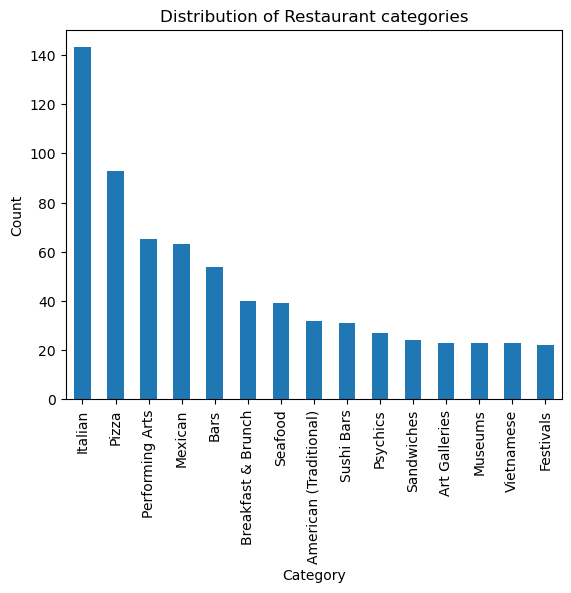

In [267]:
restaurant_category_counts.plot(kind='bar')

plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Restaurant categories')

plt.xticks(rotation=90)
plt.show()

In [253]:
### There's categories in the restaurant data that looks odd having the Art Galleries and Museums

Excluding the categories that don't make sense to seen distributions

In [260]:
excluded_categories = ['Performing Arts','Psychics', 'Art Galleries','Museums','Festivals','Cinema',"Supernatural Readings"]
new_cat_count = nyc_paris_combined['First Listed Category'].value_counts()
excl_category_counts = new_cat_count[~new_cat_count.index.isin(excluded_categories)]

top_15_cat = excl_category_counts.head(15)

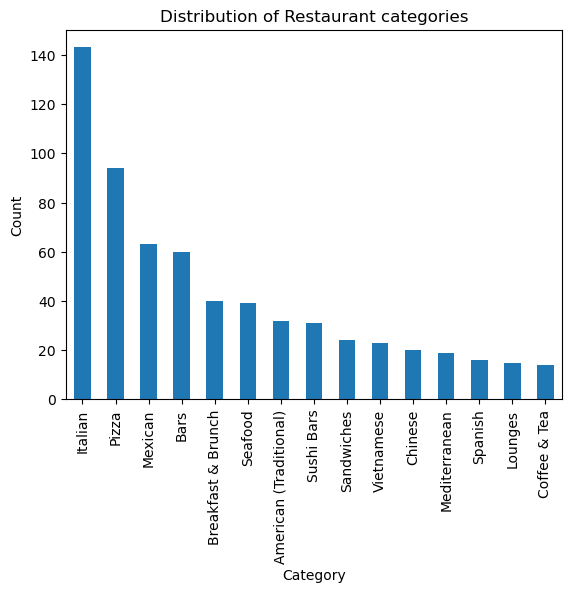

In [276]:
top_15_cat.plot(kind='bar')

plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Restaurant categories')

plt.xticks(rotation=90)
plt.show()

In [281]:
nyc = nyc_paris_combined[nyc_paris_combined['location.state'] == 'NY']
paris = nyc_paris_combined[nyc_paris_combined['location.country']== 'FR']

In [292]:
nyc_cuisine_counts = nyc['First Listed Category'].value_counts()
paris_cuisine_counts = paris['First Listed Category'].value_counts()

nyc_excl_cuisine_counts = nyc_cuisine_counts[~nyc_cuisine_counts.index.isin(excluded_categories)]
paris_excl_cuisine_counts = paris_cuisine_counts[~paris_cuisine_counts.index.isin(excluded_categories)]

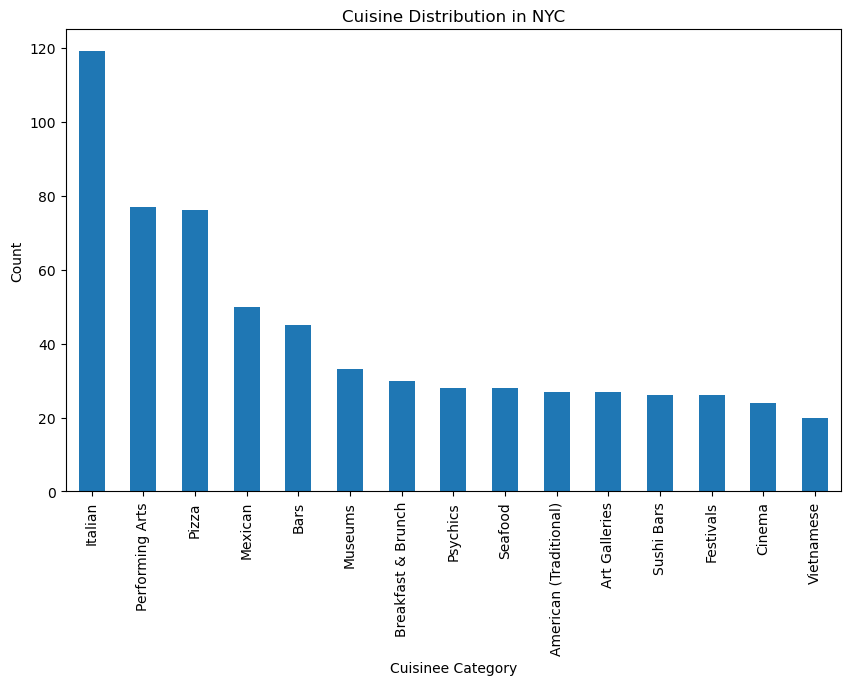

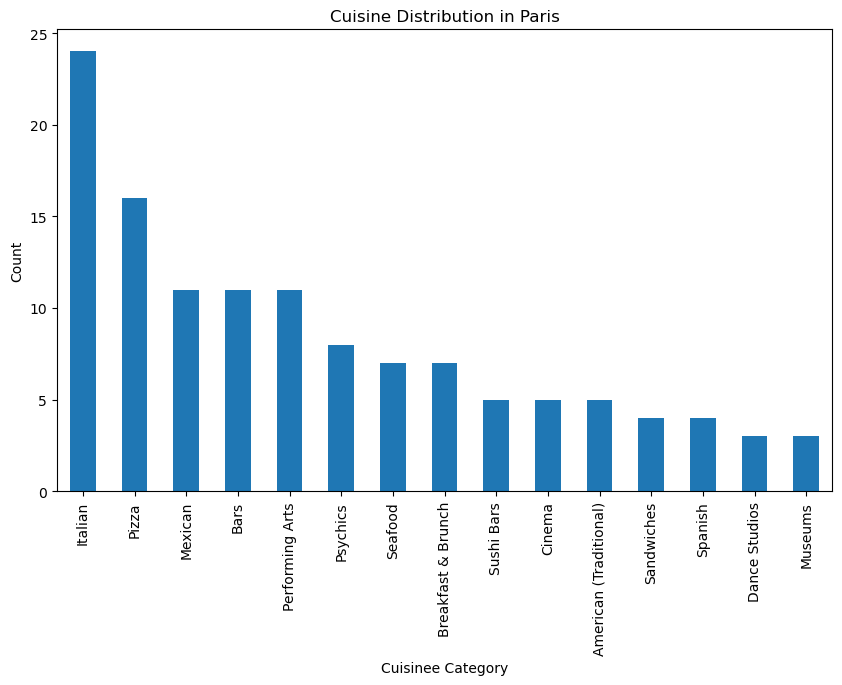

In [290]:
plt.figure()
nyc_cuisine_counts[:15].plot(kind='bar')
plt.title('Cuisine Distribution in NYC')
plt.xlabel('Cuisinee Category')
plt.ylabel('Count')
plt.xticks(rotation = 90)
plt.show()

plt.figure()
paris_cuisine_counts[:15].plot(kind='bar')
plt.title('Cuisine Distribution in Paris')
plt.xlabel('Cuisinee Category')
plt.ylabel('Count')
plt.xticks(rotation = 90)
plt.show()

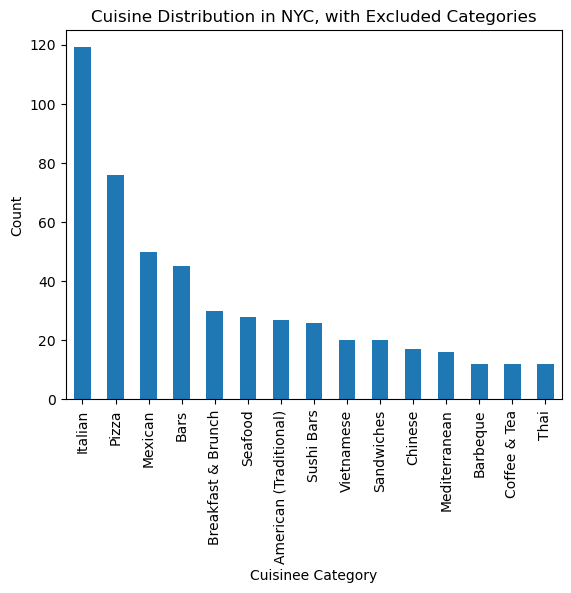

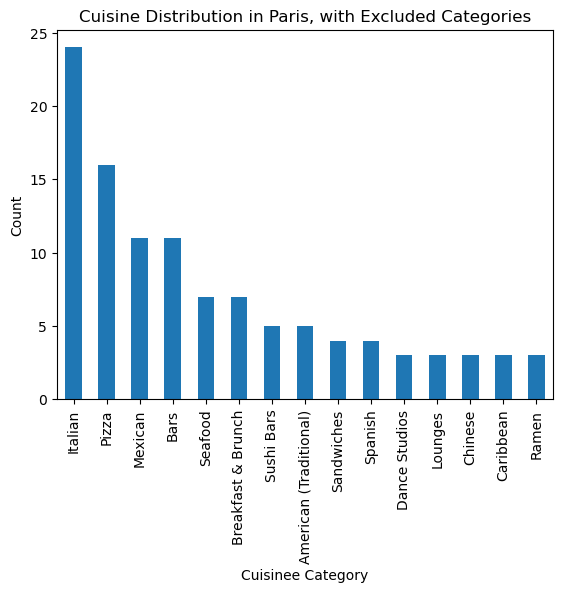

In [309]:
plt.figure()
nyc_excl_cuisine_counts[:15].plot(kind='bar')
plt.title('Cuisine Distribution in NYC, with Excluded Categories')
plt.xlabel('Cuisinee Category')
plt.ylabel('Count')
plt.xticks(rotation = 90)
plt.show()

plt.figure()
paris_excl_cuisine_counts[:15].plot(kind='bar')
plt.title('Cuisine Distribution in Paris, with Excluded Categories')
plt.xlabel('Cuisinee Category')
plt.ylabel('Count')
plt.xticks(rotation = 90)
plt.show()

In [318]:
nyc['location.city'].value_counts()

New York         1467
Brooklyn         1063
Bronx             306
Staten Island     297
Queens            141
                 ... 
Eltingville         1
Riverdale           1
Kew garden          1
Annadale            1
Coney Island        1
Name: location.city, Length: 167, dtype: int64

Capturing the 5 boroughs from the full NYC data

In [315]:
nyc

,Unnamed: 0,id,alias,name,is_closed,review_count,categories,rating,transactions,distance,coordinates.latitude,coordinates.longitude,location.address1,location.address2,location.address3,location.city,location.zip_code,location.country,location.state,location.display_address,price,total,region,Restaurant or Attraction?,First Listed Category
0,0,c6A3P3Az_Ft2NT2ReqqxDw,kpot-korean-bbq-and-hot-pot-staten-island,KPOT Korean BBQ & Hot Pot,False,70,"Hot Pot, Korean, Barbeque",4.0,[],837.302801,40.624800,-74.146730,1756 Forest Ave,NaN,NaN,Staten Island,10314,US,NY,"['1756 Forest Ave', 'Staten Island, NY 10314']",NaN,680,"{'center': {'longitude': -74.13917541503906, '...",Restaurant,Hot Pot
1,1,jUvcr86vD9BIO2jh6kRqdA,sallys-southern-staten-island,Sally's Southern,False,137,"Southern, Cocktail Bars",4.0,"['delivery', 'pickup']",3010.862313,40.630993,-74.103560,427 Forest Ave,NaN,NaN,Staten Island,10301,US,NY,"['427 Forest Ave', 'Staten Island, NY 10301']",$$,680,"{'center': {'longitude': -74.13917541503906, '...",Restaurant,Southern
2,2,jPA2Y49USanbWUaATy2M1Q,whiskey-hideaway-staten-island,Whiskey Hideaway,False,10,"Bars, American (New), Salad",4.0,"['delivery', 'pickup']",3275.110797,40.626523,-74.177854,2645 Forest Ave,NaN,NaN,Staten Island,10303,US,NY,"['2645 Forest Ave', 'Staten Island, NY 10303']",NaN,680,"{'center': {'longitude': -74.13917541503906, '...",Restaurant,Bars
3,3,qjXesvWGdDlLDKFWTlf88A,goku-kitchen-staten-island,Goku Kitchen,False,18,Asian Fusion,4.5,"['delivery', 'pickup']",472.873168,40.625215,-74.136438,1419 Forest Ave,NaN,NaN,Staten Island,10302,US,NY,"['1419 Forest Ave', 'Staten Island, NY 10302']",NaN,680,"{'center': {'longitude': -74.13917541503906, '...",Restaurant,Asian Fusion
4,4,Y3zM9U17UdLTKXJWD-mBQA,farington-s-cafe-and-restaurant-staten-island,Farington’s Cafe and Restaurant,False,8,"Italian, American (Traditional), Sandwiches",4.5,"['delivery', 'restaurant_reservation', 'pickup']",3714.983621,40.600512,-74.162310,1949 Richmond Ave,Ste 7,NaN,Staten Island,10314,US,NY,"['1949 Richmond Ave', 'Ste 7', 'Staten Island,...",NaN,680,"{'center': {'longitude': -74.13917541503906, '...",Restaurant,Italian
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3629,1779,cIK9wwlaGTze7bFMTfGLYQ,cosmic-wizard-tattoo-and-3d-uv-gallery-queens,Cosmic Wizard Tattoo & 3D UV Gallery,False,3,NaN,5.0,[],715.959150,40.706206,-73.910766,509 Onderdonk Ave,NaN,NaN,Queens,11385,US,NY,"['509 Onderdonk Ave', 'Queens, NY 11385']",NaN,633,"{'center': {'longitude': -73.91841888427734, '...",Attraction,NaN
3644,1794,yT1JXOeJ8qit9I-nikISxw,moonrise-brooklyn,Moonrise,False,8,NaN,3.5,[],402.098031,40.706340,-73.921090,1329 Willoughby Ave,NaN,NaN,Brooklyn,11237,US,NY,"['1329 Willoughby Ave', 'Brooklyn, NY 11237']",NaN,633,"{'center': {'longitude': -73.91841888427734, '...",Attraction,NaN
3647,1797,yXkibW4aTbHlmorIkGSg_Q,théâtre-xiv-by-company-xiv-brooklyn,Théâtre XIV by Company XIV,False,105,NaN,4.5,[],510.788957,40.706053,-73.923378,383 Troutman St,NaN,NaN,Brooklyn,11237,US,NY,"['383 Troutman St', 'Brooklyn, NY 11237']",$$$,633,"{'center': {'longitude': -73.91841888427734, '...",Attraction,NaN
3651,1801,adhIXIt4OY6FW7iVU1xZCw,gamehaus-new-york-queens-2,Gamehaus New York,False,64,NaN,4.0,"['pickup', 'delivery']",5349.403711,40.742143,-73.956073,5-14 51st Ave,NaN,NaN,Queens,11101,US,NY,"['5-14 51st Ave', 'Queens, NY 11101']",$$,633,"{'center': {'longitude': -73.91841888427734, '...",Attraction,NaN


In [324]:
si_clean = nyc[nyc['location.city'].str.contains('Staten Island', case=False)]
man_clean = nyc[nyc['location.city'].str.contains('Manhattan', case=False)]
bronx_clean = nyc[nyc['location.city'].str.contains('Bronx', case=False)]
queens_clean = nyc[nyc['location.city'].str.contains('Queens', case=False)]
brook_clean = nyc[nyc['location.city'].str.contains('Brooklyn', case=False)]

In [325]:
man_clean

,Unnamed: 0,id,alias,name,is_closed,review_count,categories,rating,transactions,distance,coordinates.latitude,coordinates.longitude,location.address1,location.address2,location.address3,location.city,location.zip_code,location.country,location.state,location.display_address,price,total,region,Restaurant or Attraction?,First Listed Category
845,245,i5Tl0ptqotaHdk-yL-Dxyg,balloonscapes-entertainment-manhattan,Balloonscapes Entertainment,False,4,"Performing Arts, Balloon Services, Face Painting",4.5,[],43093.952925,40.829966,-73.948300,NaN,NaN,NaN,Manhattan,10031,US,NY,"['Manhattan, NY 10031']",NaN,77,"{'center': {'longitude': -74.23307418823242, '...",Attraction,Performing Arts
31,31,1KGvtMU7VBcdlvxo2brdQg,clove-indian-restaurant-and-bar-new-york,Clove Indian Restaurant I,False,329,"American (Traditional), Irish Pub",4.0,"['delivery', 'pickup']",506.570306,40.821262,-73.950684,1592 Amsterdam Ave,Flr 1,NaN,Manhattan,10031,US,NY,"['1592 Amsterdam Ave', 'Flr 1', 'Manhattan, NY...",$$,3700,"{'center': {'longitude': -73.9493179321289, 'l...",Restaurant,American (Traditional)
874,874,D5bDIe51iMmf62A7hjgXxw,jus-bad-food-manhattan,Jus' Bad Food,False,3,NaN,4.5,[],456.982596,40.758162,-73.954688,408 S Main St,NaN,NaN,Manhattan,10044,US,NY,"['408 S Main St', 'Manhattan, NY 10044']",NaN,10700,"{'center': {'longitude': -73.95086288452148, '...",Restaurant,NaN
2166,16,i5Tl0ptqotaHdk-yL-Dxyg,balloonscapes-entertainment-manhattan,Balloonscapes Entertainment,False,4,NaN,4.5,[],475.456678,40.829966,-73.948300,NaN,NaN,NaN,Manhattan,10031,US,NY,"['Manhattan, NY 10031']",NaN,207,"{'center': {'longitude': -73.9493179321289, 'l...",Attraction,NaN
2267,117,eJsQsRRgAnR50-mPmcr7-Q,capriccio-ensemble-manhattan,Capriccio Ensemble,False,7,NaN,5.0,[],397.549744,40.854016,-73.937402,565 Ft Washington Ave,Ste D,NaN,Manhattan,10033,US,NY,"['565 Ft Washington Ave', 'Ste D', 'Manhattan,...",NaN,63,"{'center': {'longitude': -73.93352508544922, '...",Attraction,NaN
2273,123,1bl8IFw3MgOQagToNlfApw,melindas-childrens-parties-inc-manhattan,Melinda's Children's Parties Inc,False,20,NaN,5.0,[],5127.169360,40.808018,-73.950722,230 W 123rd St,Ste 4C,NaN,Manhattan,10027,US,NY,"['230 W 123rd St', 'Ste 4C', 'Manhattan, NY 10...",NaN,63,"{'center': {'longitude': -73.93352508544922, '...",Attraction,NaN
2278,128,-uV4zlj00zG18rr6if9tCw,casa-de-cultura-navarrete-manhattan,Casa de Cultura Navarrete,False,1,NaN,4.0,[],901.822952,40.845207,-73.938896,4111 Broadway,Fl 2,NaN,Manhattan,10032,US,NY,"['4111 Broadway', 'Fl 2', 'Manhattan, NY 10032']",NaN,63,"{'center': {'longitude': -73.93352508544922, '...",Attraction,NaN
2292,142,szK1OQdH7mf7NL54QtuKTQ,dj-gatsby-and-dapper-sounds-manhattan-2,DJ Gatsby & Dapper Sounds,False,22,NaN,5.0,[],14103.300244,40.732691,-73.989435,115 4th Ave,NaN,NaN,Manhattan,10003,US,NY,"['115 4th Ave', 'Manhattan, NY 10003']",NaN,63,"{'center': {'longitude': -73.93352508544922, '...",Attraction,NaN
2293,143,-G1BlxNKuy9pR_HzNJnjig,thepositivemedium-manhattan-3,ThePositiveMedium,False,4,NaN,5.0,[],8552.510138,40.777870,-73.956780,NaN,NaN,NaN,Manhattan,10028,US,NY,"['Manhattan, NY 10028']",NaN,63,"{'center': {'longitude': -73.93352508544922, '...",Attraction,NaN
2423,273,h-_H-aVqLqSZ_Lnwemro1w,poets-den-gallery-and-theater-manhattan,Poet's Den Gallery and Theater,False,4,NaN,2.5,[],1597.159683,40.791780,-73.940840,309 E 108th St,NaN,NaN,Manhattan,10029,US,NY,"['309 E 108th St', 'Manhattan, NY 10029']",NaN,228,"{'center': {'longitude': -73.95360946655273, '...",Attraction,NaN


Getting the First listed Cuisine counts for each NYC Borough with all categories and with the excluded categories

In [327]:
si_cuisine_counts = si_clean['First Listed Category'].value_counts()
si_excl_cuisine_counts = si_cuisine_counts[~si_cuisine_counts.index.isin(excluded_categories)]

man_cuisine_counts = man_clean['First Listed Category'].value_counts()
man_excl_cuisine_counts = man_cuisine_counts[~man_cuisine_counts.index.isin(excluded_categories)]

bronx_cuisine_counts = bronx_clean['First Listed Category'].value_counts()
bronx_excl_cuisine_counts = bronx_cuisine_counts[~bronx_cuisine_counts.index.isin(excluded_categories)]

queens_cuisine_counts = queens_clean['First Listed Category'].value_counts()
queens_excl_cuisine_counts = queens_cuisine_counts[~queens_cuisine_counts.index.isin(excluded_categories)]

brook_cuisine_counts = brook_clean['First Listed Category'].value_counts()
brook_excl_cuisine_counts = brook_cuisine_counts[~brook_cuisine_counts.index.isin(excluded_categories)]

In [328]:
# fig, axs = plt.subplot(2,3,figsize=(15,10))
# axs = axs.ravel()

# # Staten Island
# si_cuisine_counts[:15].plot(kind='barh', ax=axs[0])
# axs[0].set_title('Cuisine Distribution - Staten Island')
# axs[0].set_xlabel('Count')
# axs[0].set_ylabel('Cuisine Category')

# # Manhatten
# man_cuisine_counts[:15].plot(kind='barh', ax=axs[1])
# axs[1].set_title('Cuisine Distribution - Manhatten')
# axs[1].set_xlabel('Count')
# axs[1].set_ylabel('Cuisine Category')

# # Bronx
# bronx_cuisine_counts[:15].plot(kind='barh', ax=axs[2])
# axs[2].set_title('Cuisine Distribution - Bronx')
# axs[2].set_xlabel('Count')
# axs[2].set_ylabel('Cuisine Category')

# # Queens 
# queens_cuisine_counts[:15].plot(kind='barh', ax=axs[3])
# axs[3].set_title('Cuisine Distribution - Queens')
# axs[3].set_xlabel('Count')
# axs[3].set_ylabel('Cuisine Category')

# # Brooklyn
# brook_cuisine_counts[:15].plot(kind='barh', ax=axs[4])
# axs[4].set_title('Cuisine Distribution - Brooklyn')
# axs[4].set_xlabel('Count')
# axs[4].set_ylabel('Cuisine Category')


# plt.tight_layout()
# plt.show()

Staten Island

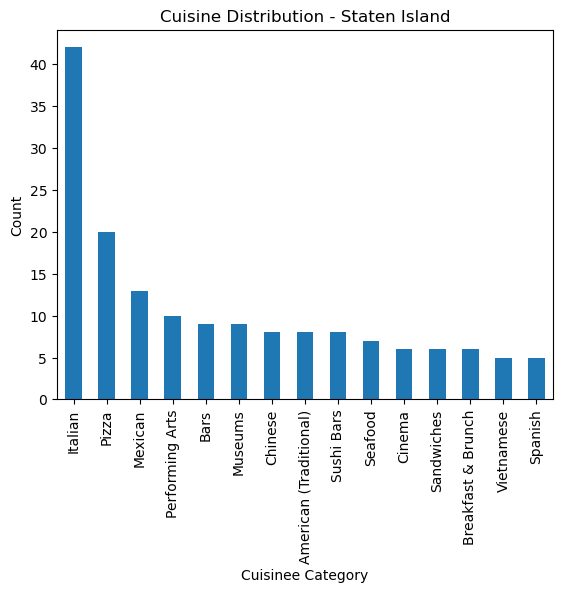

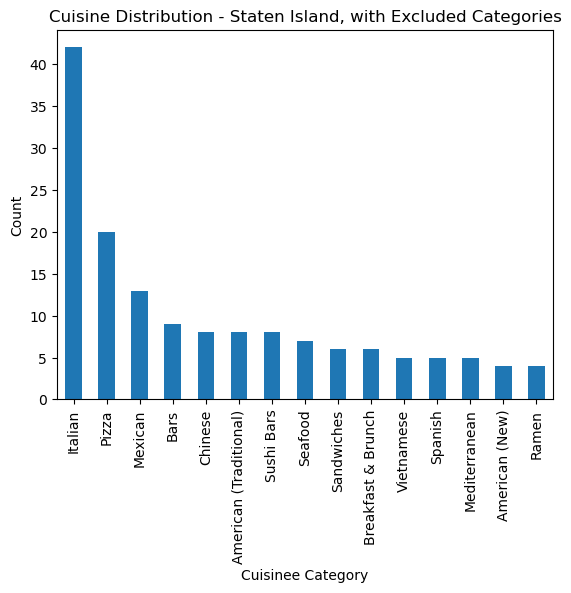

In [329]:
plt.figure()
si_cuisine_counts[:15].plot(kind='bar')
plt.title('Cuisine Distribution - Staten Island')
plt.xlabel('Cuisinee Category')
plt.ylabel('Count')
plt.xticks(rotation = 90)
plt.show()

plt.figure()
si_excl_cuisine_counts[:15].plot(kind='bar')
plt.title('Cuisine Distribution - Staten Island, with Excluded Categories')
plt.xlabel('Cuisinee Category')
plt.ylabel('Count')
plt.xticks(rotation = 90)
plt.show()

In [330]:
man_cuisine_counts

Performing Arts           1
American (Traditional)    1
Name: First Listed Category, dtype: int64

Manhatten 

- Has issues pulling in Manhattan as a city

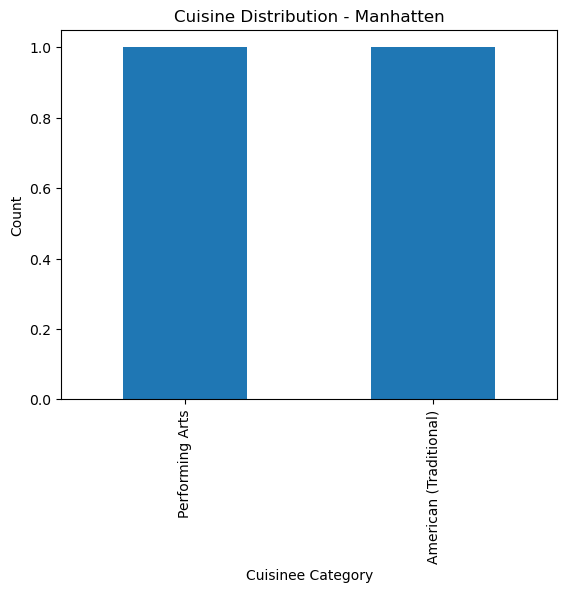

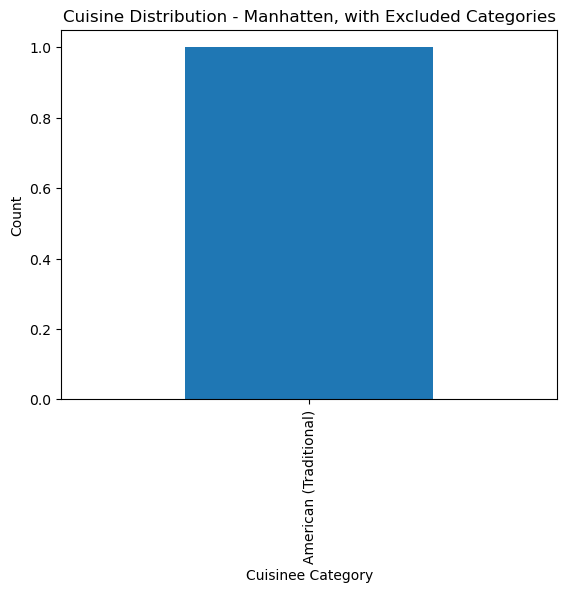

In [331]:
plt.figure()
man_cuisine_counts[:15].plot(kind='bar')
plt.title('Cuisine Distribution - Manhatten')
plt.xlabel('Cuisinee Category')
plt.ylabel('Count')
plt.xticks(rotation = 90)
plt.show()

plt.figure()
man_excl_cuisine_counts[:15].plot(kind='bar')
plt.title('Cuisine Distribution - Manhatten, with Excluded Categories')
plt.xlabel('Cuisinee Category')
plt.ylabel('Count')
plt.xticks(rotation = 90)
plt.show()

Bronx

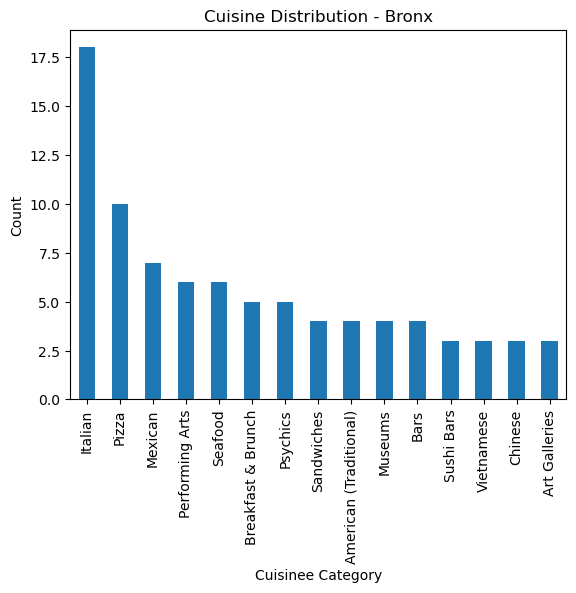

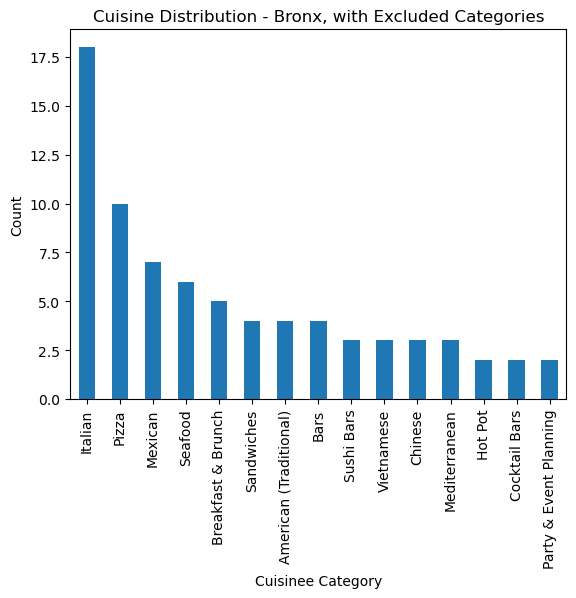

In [332]:
plt.figure()
bronx_cuisine_counts[:15].plot(kind='bar')
plt.title('Cuisine Distribution - Bronx')
plt.xlabel('Cuisinee Category')
plt.ylabel('Count')
plt.xticks(rotation = 90)
plt.show()

plt.figure()
bronx_excl_cuisine_counts[:15].plot(kind='bar')
plt.title('Cuisine Distribution - Bronx, with Excluded Categories')
plt.xlabel('Cuisinee Category')
plt.ylabel('Count')
plt.xticks(rotation = 90)
plt.show()

Queens

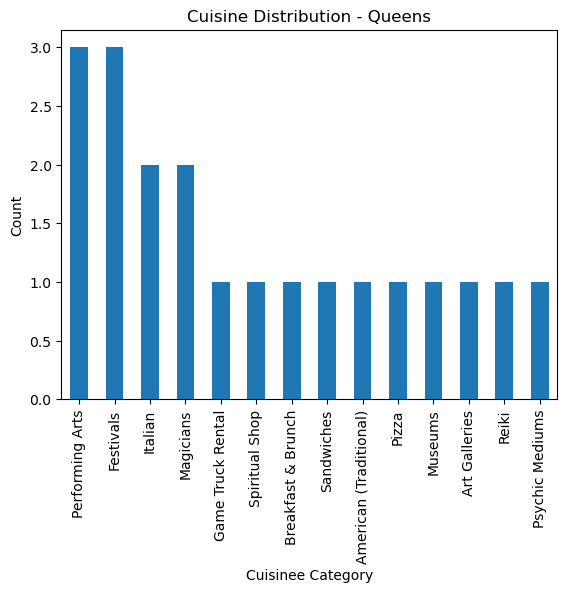

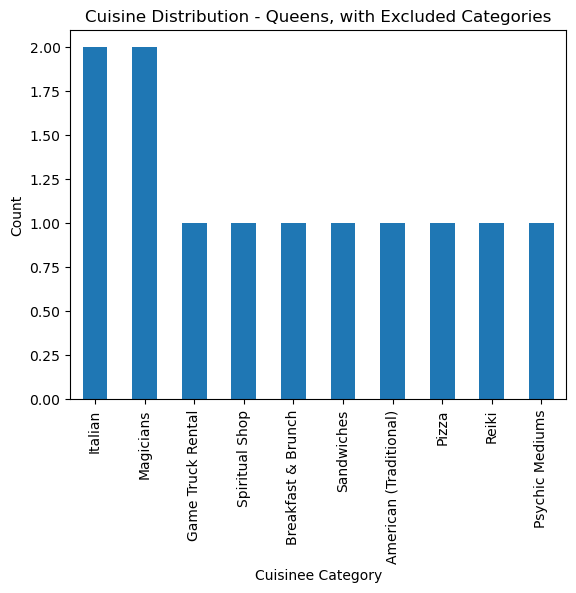

In [333]:
plt.figure()
queens_cuisine_counts[:15].plot(kind='bar')
plt.title('Cuisine Distribution - Queens')
plt.xlabel('Cuisinee Category')
plt.ylabel('Count')
plt.xticks(rotation = 90)
plt.show()

plt.figure()
queens_excl_cuisine_counts[:15].plot(kind='bar')
plt.title('Cuisine Distribution - Queens, with Excluded Categories')
plt.xlabel('Cuisinee Category')
plt.ylabel('Count')
plt.xticks(rotation = 90)
plt.show()

Brooklyn

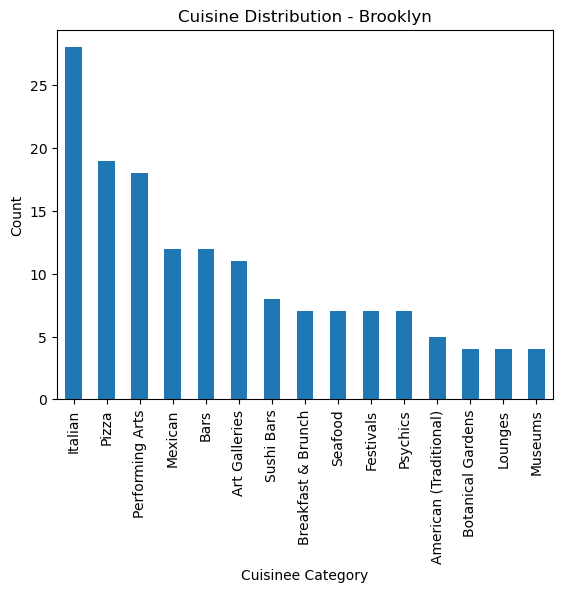

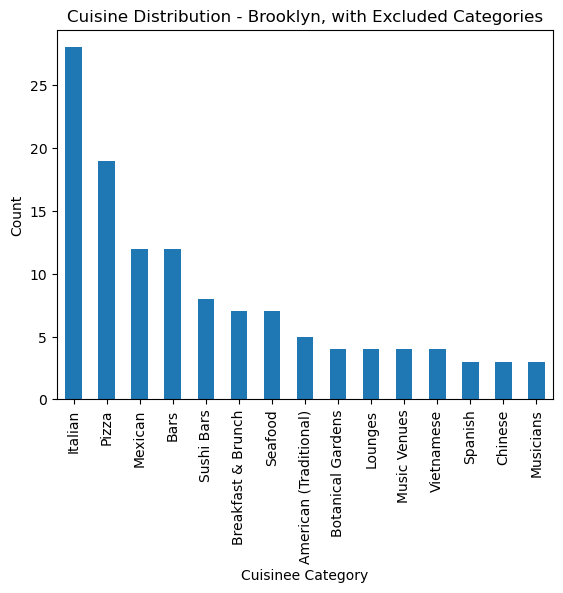

In [334]:
plt.figure()
brook_cuisine_counts[:15].plot(kind='bar')
plt.title('Cuisine Distribution - Brooklyn')
plt.xlabel('Cuisinee Category')
plt.ylabel('Count')
plt.xticks(rotation = 90)
plt.show()

plt.figure()
brook_excl_cuisine_counts[:15].plot(kind='bar')
plt.title('Cuisine Distribution - Brooklyn, with Excluded Categories')
plt.xlabel('Cuisinee Category')
plt.ylabel('Count')
plt.xticks(rotation = 90)
plt.show()

## Ratings Analysis

In [335]:
all_ratings = nyc_paris_combined['rating']

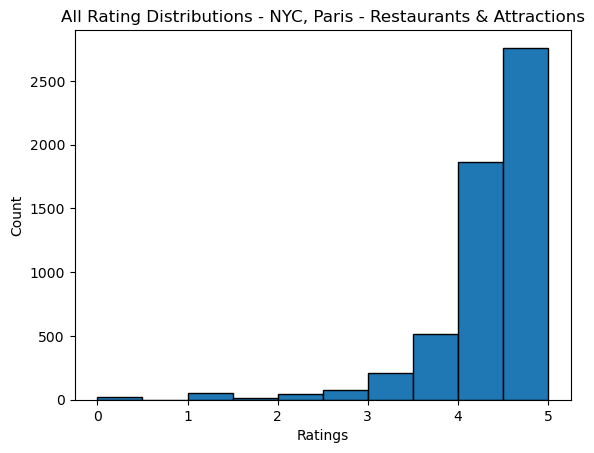

In [336]:
plt.hist(all_ratings,bins=10, edgecolor='black')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.title('All Rating Distributions - NYC, Paris - Restaurants & Attractions')
plt.show()

In [339]:
mean_all_rating = all_ratings.mean()
median_all_rating = all_ratings.median()
std_all_rating = all_ratings.std()

print(f'''Mean: {mean_all_rating}
Median: {median_all_rating}
Standard Deviation: {std_all_rating}
''')

Mean: 4.163006300630063
Median: 4.0
Standard Deviation: 0.7005383745265572



In [342]:
# plt.boxplot(all_ratings)
# plt.xlabel('Ratings')
# plt.ylabel('Boxplot of All Ratings')
# plt.show()

In [343]:
nyc_rest_ratings = nyc['rating']
paris_rest_ratings = paris['rating']

si_rest_ratings = si_clean['rating']
man_rest_ratings = man_clean['rating']
bronx_rest_ratings = bronx_clean['rating']
queens_rest_ratings = queens_clean['rating']
brook_rest_rating = brook_clean['rating']

All of NYC Restaurant Ratings and Paris Restaurant Ratings

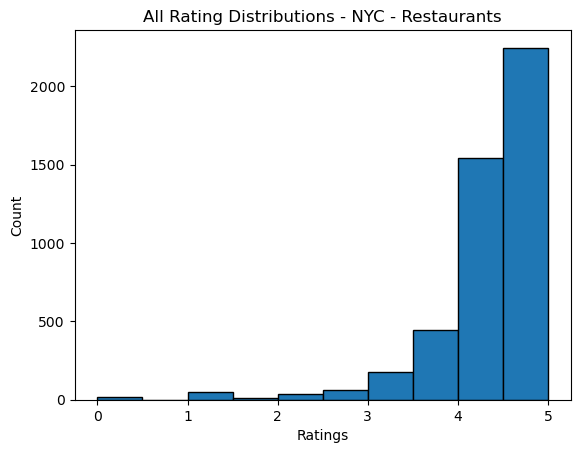

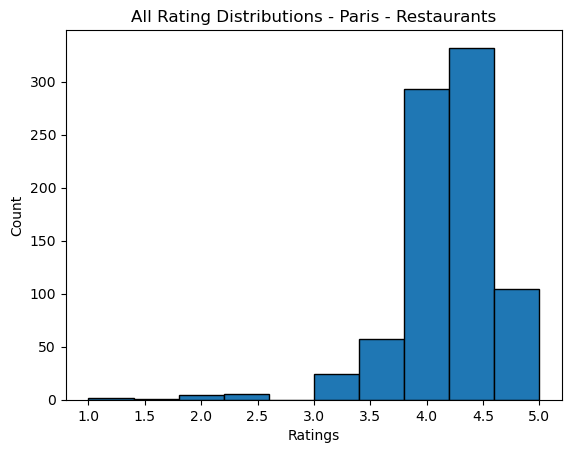

In [345]:
plt.hist(nyc_rest_ratings,bins=10, edgecolor='black')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.title('All Rating Distributions - NYC - Restaurants')
plt.show()

plt.hist(paris_rest_ratings,bins=10, edgecolor='black')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.title('All Rating Distributions - Paris - Restaurants')
plt.show()



Rating Distribution of each borough

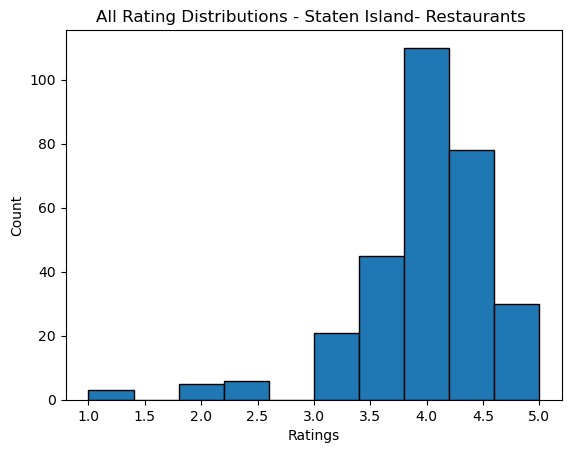

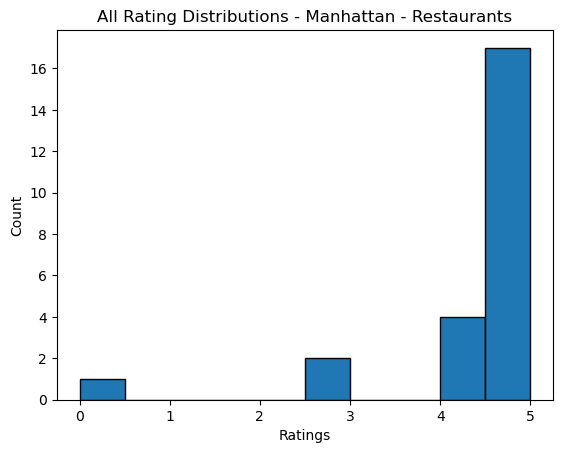

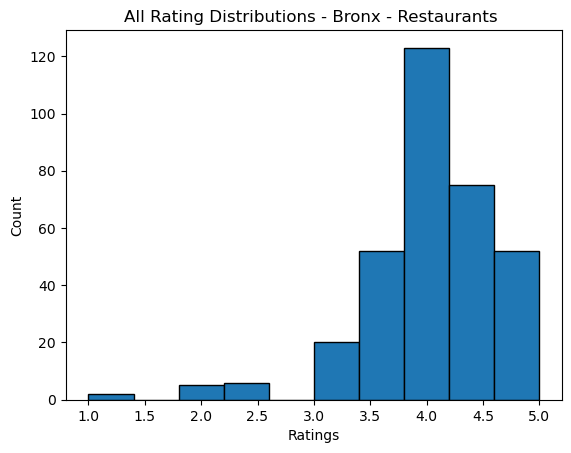

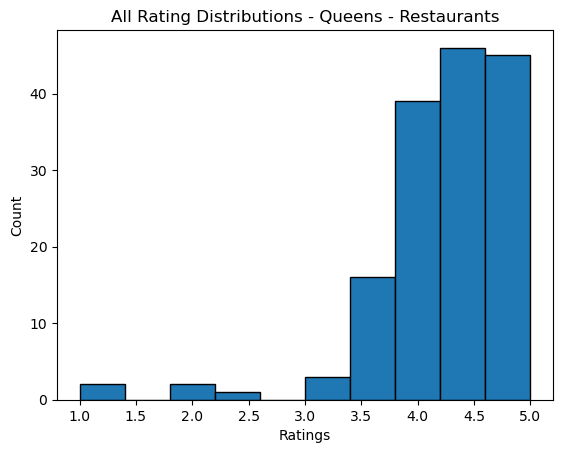

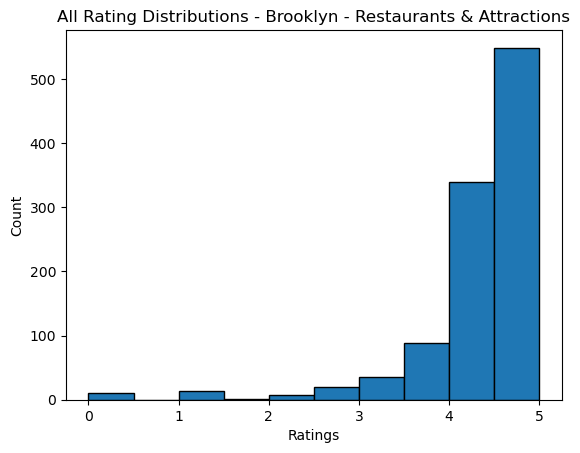

In [347]:
plt.hist(si_rest_ratings,bins=10, edgecolor='black')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.title('All Rating Distributions - Staten Island- Restaurants ')
plt.show()

plt.hist(man_rest_ratings,bins=10, edgecolor='black')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.title('All Rating Distributions - Manhattan - Restaurants')
plt.show()

plt.hist(bronx_rest_ratings,bins=10, edgecolor='black')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.title('All Rating Distributions - Bronx - Restaurants ')
plt.show()

plt.hist(queens_rest_ratings,bins=10, edgecolor='black')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.title('All Rating Distributions - Queens - Restaurants')
plt.show()

plt.hist(brook_rest_rating,bins=10, edgecolor='black')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.title('All Rating Distributions - Brooklyn - Restaurants & Attractions')
plt.show()


Descriptive Statistics

In [350]:
mean_nyc_rating = nyc_rest_ratings.mean()
median_nyc_rating = nyc_rest_ratings.median()
std_nyc_rating = nyc_rest_ratings.std()


print("NYC Descriptive Statisics")
print('=========================')
print(f'''Mean: {mean_nyc_rating}
Median: {median_nyc_rating}
Standard Deviation: {std_nyc_rating}
''')

mean_paris_rating = paris_rest_ratings.mean()
median_paris_rating = paris_rest_ratings.median()
std_paris_rating = paris_rest_ratings.std()


print("Paris Descriptive Statisics")
print('===========================')
print(f'''Mean: {mean_paris_rating}
Median: {median_paris_rating}
Standard Deviation: {std_paris_rating}
''')

NYC Descriptive Statisics
Mean: 4.149269993462628
Median: 4.0
Standard Deviation: 0.7217885090553164

Paris Descriptive Statisics
Mean: 4.235401459854015
Median: 4.5
Standard Deviation: 0.5306671019611388



In [351]:
mean_si_rating = si_rest_ratings.mean()
median_si_rating = si_rest_ratings.median()
std_si_rating = si_rest_ratings.std()


print("Staten Island Descriptive Statisics")
print('===================================')
print(f'''Mean: {mean_si_rating}
Median: {median_si_rating}
Standard Deviation: {std_si_rating}
''')

mean_man_rating = man_rest_ratings.mean()
median_man_rating = man_rest_ratings.median()
std_man_rating = man_rest_ratings.std()


print("Manhattan Descriptive Statisics")
print('===============================')
print(f'''Mean: {mean_man_rating}
Median: {median_man_rating}
Standard Deviation: {std_man_rating}
''')

mean_bronx_rating = bronx_rest_ratings.mean()
median_bronx_rating = bronx_rest_ratings.median()
std_bronx_rating = bronx_rest_ratings.std()


print("Bronx Descriptive Statisics")
print('===========================')
print(f'''Mean: {mean_bronx_rating}
Median: {median_bronx_rating}
Standard Deviation: {std_bronx_rating}
''')

mean_queens_rating = queens_rest_ratings.mean()
median_queens_rating = queens_rest_ratings.median()
std_queens_rating = queens_rest_ratings.std()


print("Queens Descriptive Statisics")
print('============================')
print(f'''Mean: {mean_queens_rating}
Median: {median_queens_rating}
Standard Deviation: {std_queens_rating}
''')

mean_brook_rating = brook_rest_rating.mean()
median_brook_rating = brook_rest_rating.median()
std_brook_rating = brook_rest_rating.std()


print("Brooklyn Descriptive Statisics")
print('==============================')
print(f'''Mean: {mean_nyc_rating}
Median: {median_nyc_rating}
Standard Deviation: {std_nyc_rating}
''')


Staten Island Descriptive Statisics
Mean: 3.9916107382550337
Median: 4.0
Standard Deviation: 0.6920156156293541

Manhattan Descriptive Statisics
Mean: 4.270833333333333
Median: 4.5
Standard Deviation: 1.151361827563783

Bronx Descriptive Statisics
Mean: 4.055223880597015
Median: 4.0
Standard Deviation: 0.6795303904343183

Queens Descriptive Statisics
Mean: 4.295454545454546
Median: 4.5
Standard Deviation: 0.7154084631608794

Brooklyn Descriptive Statisics
Mean: 4.149269993462628
Median: 4.0
Standard Deviation: 0.7217885090553164



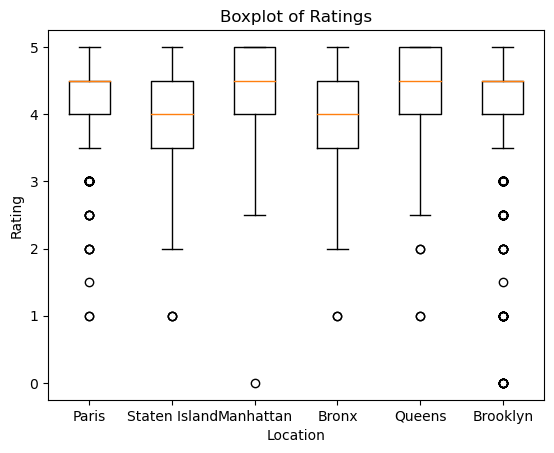

In [353]:
all_rest_ratings = [paris_rest_ratings,si_rest_ratings,man_rest_ratings,bronx_rest_ratings,queens_rest_ratings,brook_rest_rating]

plt.boxplot(all_rest_ratings, labels=['Paris','Staten Island','Manhattan', 'Bronx','Queens','Brooklyn'])
plt.xlabel('Location')
plt.ylabel('Rating')
plt.title('Boxplot of Ratings')
plt.show()

## Geographical Analysis

In [356]:
from folium.plugins import MarkerCluster

In [360]:
nyc

,Unnamed: 0,id,alias,name,is_closed,review_count,categories,rating,transactions,distance,coordinates.latitude,coordinates.longitude,location.address1,location.address2,location.address3,location.city,location.zip_code,location.country,location.state,location.display_address,price,total,region,Restaurant or Attraction?,First Listed Category
0,0,c6A3P3Az_Ft2NT2ReqqxDw,kpot-korean-bbq-and-hot-pot-staten-island,KPOT Korean BBQ & Hot Pot,False,70,"Hot Pot, Korean, Barbeque",4.0,[],837.302801,40.624800,-74.146730,1756 Forest Ave,NaN,NaN,Staten Island,10314,US,NY,"['1756 Forest Ave', 'Staten Island, NY 10314']",NaN,680,"{'center': {'longitude': -74.13917541503906, '...",Restaurant,Hot Pot
1,1,jUvcr86vD9BIO2jh6kRqdA,sallys-southern-staten-island,Sally's Southern,False,137,"Southern, Cocktail Bars",4.0,"['delivery', 'pickup']",3010.862313,40.630993,-74.103560,427 Forest Ave,NaN,NaN,Staten Island,10301,US,NY,"['427 Forest Ave', 'Staten Island, NY 10301']",$$,680,"{'center': {'longitude': -74.13917541503906, '...",Restaurant,Southern
2,2,jPA2Y49USanbWUaATy2M1Q,whiskey-hideaway-staten-island,Whiskey Hideaway,False,10,"Bars, American (New), Salad",4.0,"['delivery', 'pickup']",3275.110797,40.626523,-74.177854,2645 Forest Ave,NaN,NaN,Staten Island,10303,US,NY,"['2645 Forest Ave', 'Staten Island, NY 10303']",NaN,680,"{'center': {'longitude': -74.13917541503906, '...",Restaurant,Bars
3,3,qjXesvWGdDlLDKFWTlf88A,goku-kitchen-staten-island,Goku Kitchen,False,18,Asian Fusion,4.5,"['delivery', 'pickup']",472.873168,40.625215,-74.136438,1419 Forest Ave,NaN,NaN,Staten Island,10302,US,NY,"['1419 Forest Ave', 'Staten Island, NY 10302']",NaN,680,"{'center': {'longitude': -74.13917541503906, '...",Restaurant,Asian Fusion
4,4,Y3zM9U17UdLTKXJWD-mBQA,farington-s-cafe-and-restaurant-staten-island,Farington’s Cafe and Restaurant,False,8,"Italian, American (Traditional), Sandwiches",4.5,"['delivery', 'restaurant_reservation', 'pickup']",3714.983621,40.600512,-74.162310,1949 Richmond Ave,Ste 7,NaN,Staten Island,10314,US,NY,"['1949 Richmond Ave', 'Ste 7', 'Staten Island,...",NaN,680,"{'center': {'longitude': -74.13917541503906, '...",Restaurant,Italian
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3629,1779,cIK9wwlaGTze7bFMTfGLYQ,cosmic-wizard-tattoo-and-3d-uv-gallery-queens,Cosmic Wizard Tattoo & 3D UV Gallery,False,3,NaN,5.0,[],715.959150,40.706206,-73.910766,509 Onderdonk Ave,NaN,NaN,Queens,11385,US,NY,"['509 Onderdonk Ave', 'Queens, NY 11385']",NaN,633,"{'center': {'longitude': -73.91841888427734, '...",Attraction,NaN
3644,1794,yT1JXOeJ8qit9I-nikISxw,moonrise-brooklyn,Moonrise,False,8,NaN,3.5,[],402.098031,40.706340,-73.921090,1329 Willoughby Ave,NaN,NaN,Brooklyn,11237,US,NY,"['1329 Willoughby Ave', 'Brooklyn, NY 11237']",NaN,633,"{'center': {'longitude': -73.91841888427734, '...",Attraction,NaN
3647,1797,yXkibW4aTbHlmorIkGSg_Q,théâtre-xiv-by-company-xiv-brooklyn,Théâtre XIV by Company XIV,False,105,NaN,4.5,[],510.788957,40.706053,-73.923378,383 Troutman St,NaN,NaN,Brooklyn,11237,US,NY,"['383 Troutman St', 'Brooklyn, NY 11237']",$$$,633,"{'center': {'longitude': -73.91841888427734, '...",Attraction,NaN
3651,1801,adhIXIt4OY6FW7iVU1xZCw,gamehaus-new-york-queens-2,Gamehaus New York,False,64,NaN,4.0,"['pickup', 'delivery']",5349.403711,40.742143,-73.956073,5-14 51st Ave,NaN,NaN,Queens,11101,US,NY,"['5-14 51st Ave', 'Queens, NY 11101']",$$,633,"{'center': {'longitude': -73.91841888427734, '...",Attraction,NaN


In [361]:
### Some locations contain NaN, have to go through and find them


center_lat = 40.7128
center_long = -74.0060

map = folium.Map(location=[center_lat,center_long], zoom_start=10)

marker_cluster = MarkerCluster().add_to(map)

for index, row in nyc.iterrows():
    lat = row['coordinates.latitude']
    long = row['coordinates.longitude']
    marker = folium.Marker([lat,long])
    marker.add_to(marker_cluster)

map

ValueError: Location values cannot contain NaNs.